# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [2]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [3]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cat
0,40585382,1
1,30005269,0
2,3314758074,0
3,14311688,0
4,110457801,0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

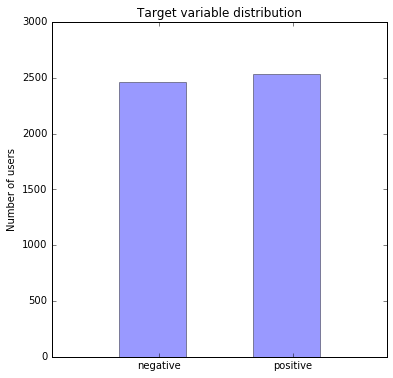

In [5]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cat"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [6]:
CONSUMER_KEY = "1w8Ph7u118iOEFtSr55jbouCj"
CONSUMER_SECRET = "mNbLMj3nGszNGPabJXFP0RmX8Av0eoM0XrAso0davvXmNBtqSR"

ACCESS_TOKEN_KEY = "219939677-T98l4vUau7NkpInpZHqIgM1CcCJ52HA9n3Wqylru"
ACCESS_TOKEN_SECRET = "b3p3EgKUkITt4ty6mDqxfcTCi1DI60wUufZRi5YYnhbAu"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничего 30к в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [7]:
GEO_USER_NAME = "mmb095"

def get_coordinates_by_location(location):
    
    """
    This function gets geographic coordinates and city name
    form external web service GeoNames using 'location' string.
    
    """
    # your code here
    par = {'q': location, 'maxRows': '1', 'username': GEO_USER_NAME}
    req = requests.get('http://api.geonames.org/searchJSON?', params=par)
    data = req.json()
    if 'totalResultsCount' in data and data["totalResultsCount"] >= 1 and 'countryName' in data["geonames"][0] and 'lat' in data["geonames"][0] and 'lng' in data["geonames"][0]:
        country = data["geonames"][0]["countryName"]
        latitude = float(data["geonames"][0]["lat"])
        longtitude = float(data["geonames"][0]["lng"])
        return (latitude, longtitude, country)
    else:
        return (None, None, None)
        

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [8]:
#import time
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record


def get_user_records(df):
    # your code here
    users_info_list = []   
    processed_locations = {} 
    start = 0
    end = 100
    while len(df[start:end]) > 0:
        user_pack = api.UsersLookup(user_id=df[start:end]['uid'].tolist())
        for user in user_pack:
            if user.location in processed_locations:            
                tmp_geo = processed_locations[user.location]
                user.location = None
                user_info = twitter_user_to_dataframe_record(user)
                user_info['lat'] = tmp_geo[0]
                user_info['lon'] = tmp_geo[1]
                user_info['country'] = tmp_geo[2]
            else:                
                user_info = twitter_user_to_dataframe_record(user)
                if 'location' in user_info:
                    processed_locations.update({user.location: (user_info['lat'], user_info['lon'], user_info['country'])})
            users_info_list.append(user_info)
            json.dump(user_info, f)
        start += 100
        end += 100
    return users_info_list

user_records = get_user_records(df_users)

print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

time.struct_time(tm_year=2016, tm_mon=3, tm_mday=3, tm_hour=17, tm_min=10, tm_sec=19, tm_wday=3, tm_yday=63, tm_isdst=0)
time.struct_time(tm_year=2016, tm_mon=3, tm_mday=3, tm_hour=17, tm_min=20, tm_sec=46, tm_wday=3, tm_yday=63, tm_isdst=0)
Creating data frame from loaded data
Merging data frame with the training set
Finished building data frame


## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://anokhin.github.io/img/hw1_distr.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (2 балла).

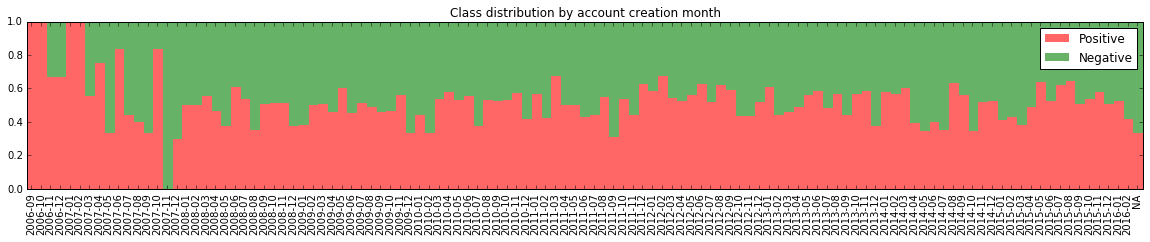

In [219]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = []
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    # your code here 
    positive = []
    negative = []
    for key, value in sorted(grouped.groups.items()):
        dts.append(key)
        current_group = grouped.get_group(key)
        date_pos_neg_amount = current_group['cat'].value_counts().tolist()
        if len(date_pos_neg_amount) == 2:
            categ = (int)(current_group['cat'].value_counts().index[0])
            if categ == 0:
                negative.append(date_pos_neg_amount[0])
                positive.append(date_pos_neg_amount[1])
            if categ == 1:
                positive.append(date_pos_neg_amount[0])
                negative.append(date_pos_neg_amount[1])
        elif len(date_pos_neg_amount) == 1:
            if current_group[0:1]['cat'].item() == 0:
                negative.append(date_pos_neg_amount[0])
                positive.append(0)
            elif current_group[0:1]['cat'].item() == 1:
                positive.append(date_pos_neg_amount[0])
                negative.append(0)
    count_pos = np.asarray(positive)
    count_neg = np.asarray(negative)
    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://anokhin.github.io/img/hw1_map.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

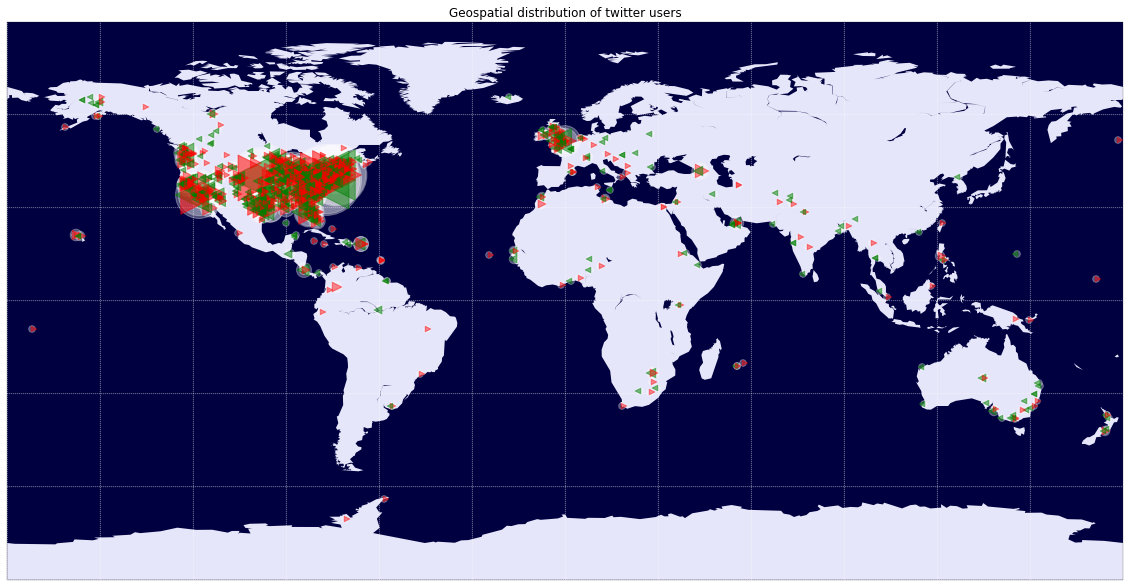

In [409]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2, zorder=1)
m.fillcontinents(color='lavender', lake_color='#000040', zorder=2)
m.drawmapboundary(linewidth=0.2, fill_color='#000040', zorder=3)
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5, zorder=4)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5, zorder=5)



def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    # your code here
    
    cat_pos_df = df_full.loc[df_full['cat'].isin([1,1])]
    cat_neg_df = df_full.loc[df_full['cat'].isin([0,0])]

    lats_neg = np.asarray(cat_neg_df['lat'])
    lats_neg = lats_neg[np.logical_not(numpy.isnan(lats_neg))].tolist()
    lons_neg = np.asarray(cat_neg_df['lon'])
    lons_neg = lons_neg[np.logical_not(numpy.isnan(lons_neg))].tolist()

    geo_neg = []
    i = 0
    for i in range (0, len(lats_neg)):
        geo_neg.append((lons_neg[i], lats_neg[i]))

    geo_df_neg = pd.DataFrame({'geo' : geo_neg})
    k_area_neg = np.asarray(geo_df_neg['geo'].value_counts()) * 30   
    center_list_neg = geo_df_neg['geo'].value_counts().index.tolist()    

#lats_pos = cat_pos_df['lat'].tolist()
    lats_pos = np.asarray(cat_pos_df['lat'])
    lats_pos = lats_pos[np.logical_not(numpy.isnan(lats_pos))].tolist()
#lons_pos = cat_pos_df['lon'].tolist()
    lons_pos = np.asarray(cat_pos_df['lon'])
    lons_pos = lons_pos[np.logical_not(numpy.isnan(lons_pos))].tolist()

    geo_pos = []
    i = 0
    for i in range (0, len(lats_pos)):
        geo_pos.append((lons_pos[i], lats_pos[i]))

    geo_df_pos = pd.DataFrame({'geo' : geo_pos})
    k_area_pos = np.asarray(geo_df_pos['geo'].value_counts()) * 30   
    center_list_pos = geo_df_pos['geo'].value_counts().index.tolist()
    
    minlength = 0
    longer = 0
    maxlength = 0
    
    if len(center_list_pos) > len(center_list_neg):
        minlength = len(center_list_neg)
        maxlength = len(center_list_pos)
        longer = 0
    else:
        minlength = len(center_list_pos)
        maxlength = len(center_list_neg)
        longer = 1

    for i in range (0, minlength):
        x_neg, y_neg = m(center_list_neg[i][0], center_list_neg[i][1])
        m.scatter(x_neg, y_neg, s = k_area_neg[i] * 1.5, marker='o', color='white', alpha=0.3, zorder=6)
        
        a = 0.45
        sh = 0.5
        if i < 10:
            a = 0.55
            sh = 2          
        
        x_neg, y_neg = m(center_list_neg[i][0] - sh, center_list_neg[i][1])
        m.scatter(x_neg, y_neg, s = k_area_neg[i], marker='<', color='green', alpha=0.5, zorder=8, edgecolors='green')
    
        x_pos, y_pos = m(center_list_pos[i][0], center_list_pos[i][1])
        m.scatter(x_pos, y_pos, s = k_area_pos[i] * 1.5, marker='o', color='white', alpha=0.3, zorder=6)
    
        x_pos, y_pos = m(center_list_pos[i][0] + 0.5, center_list_pos[i][1])
        a = 0
        if i < 10:
            a = 0.55
        else:
            a = 0.45
        m.scatter(x_pos, y_pos, s = k_area_pos[i], marker='>', color='red', alpha=a, zorder=8, edgecolors='red')

    
    diff = maxlength - minlength

    for i in range (minlength, maxlength):
        if longer:
            x_neg, y_neg = m(center_list_neg[i][0], center_list_neg[i][1])
            m.scatter(x_neg, y_neg, s = k_area_neg[i] * 1.5, marker='o', color='white', alpha=0.3, zorder=6)
            
            x_pos, y_pos = m(center_list_pos[i - diff][0] + 0.5, center_list_pos[i - diff][1])
            m.scatter(x_pos, y_pos, s = k_area_pos[i - diff], marker='>', color='red', alpha=0.6, zorder=8, edgecolors='red')
        
            x_neg, y_neg = m(center_list_neg[i][0] - 0.5, center_list_neg[i][1])
            m.scatter(x_neg, y_neg, s = k_area_neg[i], marker='<', color='green', alpha=0.2, zorder=8, edgecolors='green') 
        else:
            x_pos, y_pos = m(center_list_pos[i][0] + 0.5, center_list_pos[i][1])
            m.scatter(x_pos, y_pos, s = k_area_pos[i] * 1.5, marker='o', color='white', alpha=0.3, zorder=6)
            
            x_neg, y_neg = m(center_list_neg[i - diff][0] - 0.5, center_list_neg[i - diff][1])
            m.scatter(x_neg, y_neg, s = k_area_neg[i - diff], marker='<', color='green', alpha=0.4, zorder=8, edgecolors='green')
        
            x_pos, y_pos = m(center_list_pos[i][0] + 0.5, center_list_pos[i][1])
            m.scatter(x_pos, y_pos, s = k_area_pos[i], marker='>', color='red', alpha=0.6, zorder=8, edgecolors='red')   
    
    return

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).

Смотрим на полученный data frame и сохраняем его в .csv файл.

В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* Вместо точек маркерами являются треугольники, причем треугольники, соответствующие разным цветам, повернуты в разные строны (теперь маркеры разных цветов с центром в одной и той же точке не накладываются друг на друга полностью).
* Площадь маркера, соответствующего одной геопозиции, зависит от количества пользователей, указавших её (чем больше пользователей, тем больше площадь).
* Красные и зелёные маркеры добавляются на карту по очереди через один (самые крупные сначала, самые мелкие в конце).
* Добавлена прозрачность для всех маркеров. Красные маркеры более прозрачные, чем зелёные.
* У всех маркеров есть контур того же цвета. Контур менее прозрачный, чем маркер, но тоже просвечивает.
* Красные маркеры немного сдвинуты вправо, зеленые влево (без сдвигов для достаточно больших треугольников получалось, что центры масс красного и зелёного треугольников, соответствующих одной и той же геопозиции, находились в разных точках, что мешало восприятию; также без сдвигов красные маленькие треугольники при наложении на зелёные хуже видно).
* Для того, чтобы на территории, прилегающей к воде, были лучше видны полупрозрачные маркеры, для каждой рассматриваемой геопозиции добавлена белая полупрозрачная подложка под маркер в виде круга.

In [220]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cat,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,40585382,1,Reverend Sue,ReverendSue,Retired Interfaith Minister. Activist. Equalit...,False,United States,39.76000,-98.50000,United States,2009-05,7614,4284,50620,787,417
1,30005269,0,Ryan Wrasse,RWrasse,Communications Director for @SenJohnThune | Ge...,False,Capitol Hill,15.20825,145.75313,Northern Mariana Islands,2009-04,1913,1240,7143,127,96
2,3314758074,0,Campaign Trump,Campaign_Trump,#Trump for President. Indp. Local & Internatio...,False,"Houston, TX",29.76328,-95.36327,United States,2015-08,19163,12709,1168,7167,172
3,14311688,0,Bernard Whitman,BernardWhitman,"Democratic strategist, pollster, and corporate...",False,New York,40.71427,-74.00597,United States,2008-04,1757,1292,7338,157,110
4,110457801,0,Carson Ingle,caingle,Writer for @AthleteSpeakers & @NOPACTalent. 10...,False,Orlando aka The City Beautiful,NaN,NaN,None,2010-02,1468,1188,37134,3311,76
